In [2]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [3]:
# Importing playlist dataframes
df = pd.read_csv('SpotifyMarch22ML.csv')
df_fav = pd.read_csv('DonaldMarch22ML.csv')

In [4]:
# Checking if both datasets have the same columns
df.columns == df_fav.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [38]:
df_model = pd.concat([df, df_fav], axis=0)
df_model = df_model.reset_index(drop=True)
df_model.shape

(6464, 13)

In [29]:
df_model.head()

,track_id,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,favorite
0,408UEGA6FV2nvQjr1nt1VT,240000,51,0.502,0.05430,0.874,0.000001,0.4260,-3.742,0.2030,141.776,4,0
1,4XeIiGpUBshIfs9yrBDVZC,359126,77,0.633,0.00764,0.920,0.001770,0.1230,-2.812,0.0928,114.997,4,0
2,6GomT970rCOkKAyyrwJeZi,157445,83,0.848,0.01690,0.821,0.000403,0.0962,-5.408,0.0527,125.051,4,0
3,50ZFpw2wS6ERvLmW8TINhq,168053,82,0.788,0.22300,0.945,0.000003,0.1150,-5.091,0.0599,128.036,4,0
4,08Ecw0ItPxGeHS9Mexr8cs,242905,73,0.716,0.00857,0.655,0.162000,0.0572,-5.999,0.0444,125.012,4,0


In [39]:
df_model['favorite'].value_counts()

0    5847
1     617
Name: favorite, dtype: int64

Prepare Data for Modeling

In [24]:
from pandas_profiling import ProfileReport
report = ProfileReport(df_model)
report.to_file('ml_model_march_22.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


In [25]:
#check for variables with high variance
for col in df_model.columns:
    fraction_unique = df_model[col].unique().shape[0] / df_model.shape[0]
    if fraction_unique > 0.5:
        print(col)

#could add these columns to a list to drop

track_id
length
loudness
tempo


In [40]:
#Correlation Plot between features and target
plt.figure(figsize=(15,5))
df_model.corr().loc['favorite'][:-1].plot.barh()
plt.savefig('Correlation.png')

In [8]:
#Check p-values for significance. P-values greater than .05 mean we fail to reject the null hypothesis that the feature and target have correlation that is significantly close to 0. 
#P-values less than .05 mean we reject the null hypothesis and the feature and target have correlation that is significantly different than 0.
from scipy.stats import pearsonr
from pandas.api.types import is_numeric_dtype
for c in df_model.columns[:-1]:
    if is_numeric_dtype(df_model[c]):
        correlation, pvalue = pearsonr(df_model[c], df_model['favorite'])
        print(f'{c : <40}: correlation: {correlation : .4f}, p-value: {pvalue}, significant: {pvalue <= 0.05}')


length                                  : correlation:  0.1499, p-value: 8.896270477994195e-34, significant: True
popularity                              : correlation: -0.1545, p-value: 8.393667364466759e-36, significant: True
danceability                            : correlation:  0.0567, p-value: 5.084533154588712e-06, significant: True
acousticness                            : correlation: -0.0006, p-value: 0.9608465526333733, significant: False
energy                                  : correlation: -0.0021, p-value: 0.8662286336264767, significant: False
instrumentalness                        : correlation:  0.1160, p-value: 8.359592574219926e-21, significant: True
liveness                                : correlation: -0.0278, p-value: 0.025329736554863837, significant: True
loudness                                : correlation: -0.0710, p-value: 1.091732277986825e-08, significant: True
speechiness                             : correlation: -0.0455, p-value: 0.000250532375870220

In [34]:
# Importing required libraries
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics 
from sklearn.metrics import f1_score
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier

In [47]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['favorite', 'track_id', 'tempo', 'acousticness', 'time_signature', 'energy'])
y = df_model.favorite

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [48]:
x_train.head()

,length,popularity,danceability,instrumentalness,liveness,loudness,speechiness
4855,233500,53,0.575,0.8860,0.1280,-13.334,0.0375
383,196667,62,0.763,0.0112,0.4760,-9.063,0.0807
619,242927,46,0.617,0.8780,0.0858,-8.204,0.0433
1022,466733,50,0.685,0.7270,0.0266,-6.623,0.0563
3611,292000,36,0.820,0.7040,0.0750,-11.629,0.0488


In [49]:
# Checking for imbalance
y_train.value_counts()

0    4677
1     494
Name: favorite, dtype: int64

In [51]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegressionCV

samplers = [
 SMOTE(random_state=42),
 BorderlineSMOTE(random_state=42, kind="borderline-1"),
 BorderlineSMOTE(random_state=42, kind="borderline-2"),
 SVMSMOTE(random_state=42),
 ADASYN(random_state=42),
 SMOTEENN(random_state=42),
 SMOTETomek(random_state=42)
]
for s in samplers:
    x_resampled, y_resampled = s.fit_resample(x_train, y_train)
    lr_model_rs = LogisticRegressionCV(max_iter=1000)
    lr_model_rs.fit(x_resampled, y_resampled)
    ra_score = roc_auc_score(y_test,
    lr_model_rs.predict_proba(x_test)[:, 1])
    print(f'{str(s):<55} {ra_score}')

SMOTE(random_state=42)                                  0.6662462650267529
BorderlineSMOTE(random_state=42)                        0.6660100062539087
BorderlineSMOTE(kind='borderline-2', random_state=42)   0.6660864429157113
SVMSMOTE(random_state=42)                               0.6650649711625323
ADASYN(random_state=42)                                 0.6660516989785282
SMOTEENN(random_state=42)                               0.6660447501910917
SMOTETomek(random_state=42)                             0.6662045723021333


In [52]:
# Train / Split Data
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train) 

In [53]:
# Checking if imbalance is gone
y_train.value_counts()

1    4677
0    4677
Name: favorite, dtype: int64

Testing Models

In [57]:
%%time
# Logistic Regression
lr = LogisticRegression(solver='lbfgs', max_iter=400).fit(x_train, y_train)
lr_scores = cross_val_score(lr, x_train, y_train, cv=10, scoring="f1")
print(np.mean(lr_scores))

0.6603580308774216
Wall time: 164 ms


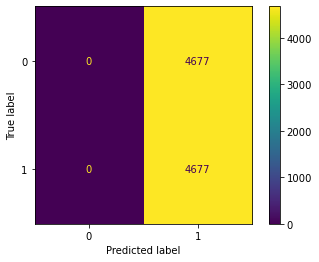

In [58]:
# Logistic Regression confusion matrix
lr_preds = lr.predict(x_train)
plot_confusion_matrix(lr, x_train, y_train)

In [60]:
# Hyperparameter optimization for Decision Tree Classifier
parameters = {
    'max_depth':[3, 4, 5, 6, 10, 15,20,30],
}
dtc = Pipeline([('CV',GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5))])
dtc.fit(x_train, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 20}

In [61]:
%%time
# Decision Tree Classifier
dt = DecisionTreeClassifier(max_depth=20).fit(x_train, y_train)
dt_scores = cross_val_score(dt, x_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

Wall time: 789 ms


0.8145387222228129

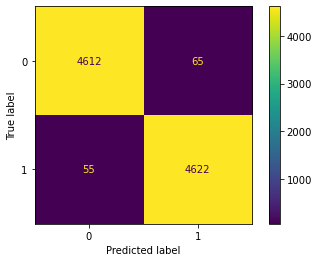

In [62]:
# Decision Tree Classifier confusion matrix
plot_confusion_matrix(dt, x_train, y_train)

In [64]:
%%time
# Hyperparameter optimization of RandomForestClassifier
parameters = {
    'max_depth':[3, 6,12,15,20],
    'n_estimators':[10, 20,30]
}
clf = Pipeline([('CV',GridSearchCV(RandomForestClassifier(), parameters, cv = 5))])
clf.fit(x_train, y_train)
clf.named_steps['CV'].best_params_

Wall time: 15.5 s


{'max_depth': 20, 'n_estimators': 30}

In [65]:
%%time
# RandomForestClassifier
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 30, max_depth = 20).fit(x_train, y_train))])
rf_scores = cross_val_score(rf, x_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

Wall time: 4.97 s


0.8809943554078433

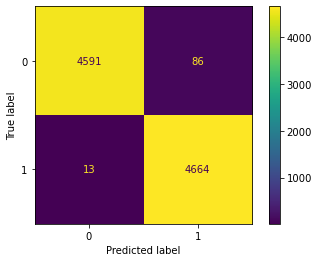

In [66]:
# Random Forest Classifier confusion matrix
plot_confusion_matrix(rf, x_train, y_train)

EDIT Although the RandomForestClassifier had the highest accuracy, the confusion matrix showed the DecisionTreeClassifier truly had the higher accuracy because it has less false positives and negatives.

Therefore, I will be using the DecisionTreeClassifier as my recommendation algorithm.

In [67]:
# Checking for imbalance
y_test.value_counts()

0    1170
1     123
Name: favorite, dtype: int64

In [70]:
# Building a pipeline to use on regular data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 30, max_depth = 20))
pipe.fit(x_train, y_train)  # apply scaling on training data
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rf', RandomForestClassifier(n_estimators = 30, max_depth = 20))])

pipe.score(x_test, y_test)

0.8368136117556071

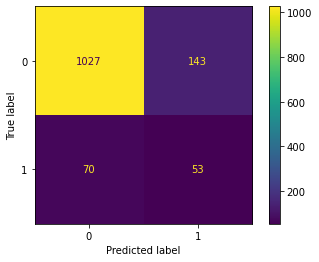

In [72]:
plot_confusion_matrix(rf, x_test, y_test)

In [74]:
# Reloading the original dataframe to test the model on
dfplaylist = pd.read_csv('SpotifyMarch22ML.csv')

In [76]:
dfplaylist.shape

(5847, 13)

In [87]:
# Predicting if a song is a favorite
prob_preds = pipe.predict_proba(dfplaylist.drop(['favorite', 'track_id', 'tempo', 'acousticness', 'time_signature', 'energy','prediction'], axis=1))
threshold = 0.75 # define threshold here
preds = [1 if prob_preds[i][1]> threshold else 0 for i in range(len(prob_preds))]
dfplaylist['prediction'] = preds

In [88]:
dfplaylist['prediction'].value_counts()

0    5817
1      30
Name: prediction, dtype: int64

In [89]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2

In [90]:
# Insert your Spotify username and the credentials that you obtained from spotify developer
cid = 'dcc21a37cc5043128d21d9f13ae66490'
secret = '90cbe933faf6455481044dfc6e401af0'
redirect_uri='http://localhost:7777/callback'
username = 'c0wmilker247'

In [91]:
# Once the Authorisation is complete, we just need to `sp` to call the APIs
scope = 'user-top-read playlist-modify-private playlist-modify-public'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [92]:
# Creating a function that builds a playlist in the user's spotify account
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [93]:
create_playlist(sp, username, 'Electronic Playlist Recommendation V1', 'The tracks on this playlist were recommended from Spotify\'s electronic playlists!')

In [94]:
# Function to check if the playlist was created successfully
def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [95]:
fetch_playlists(sp,username).head()

,id,name,#tracks
0,5BKeJkILyINOCMng0vlvFf,Electronic Playlist Recommendation V1,0
1,557PpzJfEp5OI3XgxhRv3D,Inject Energy,1
2,6F8QSUgbKZ6HMNWck5sBry,March ‘22,11
3,3fZFNntQKqhg7a3aio7b1i,February ‘22,21
4,6yLDq6V9mlnilT6to5f4Fw,Air I Breathe - Sub Focus & Wilkinson,1


In [96]:
# Getting the playlist ID of the most recently made playlist so we can add songs to it later
playlist_id = fetch_playlists(sp,username)['id'][0]

In [97]:
# Function to add selected songs to playlist
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 75])
        index += 75

In [98]:
# Adding songs to playlist
list_track = df.loc[df['prediction']  == 1]['track_id']
enrich_playlist(sp, username, playlist_id, list_track)